In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [1]:
using_colab = False

## Set-up

In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

/home/praks/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [4]:
import sys
sys.path.append("/home/praks/Cell_analysis_DeepLearning/sam2")

from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/usr/Cell_analysis_DeepLearning/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

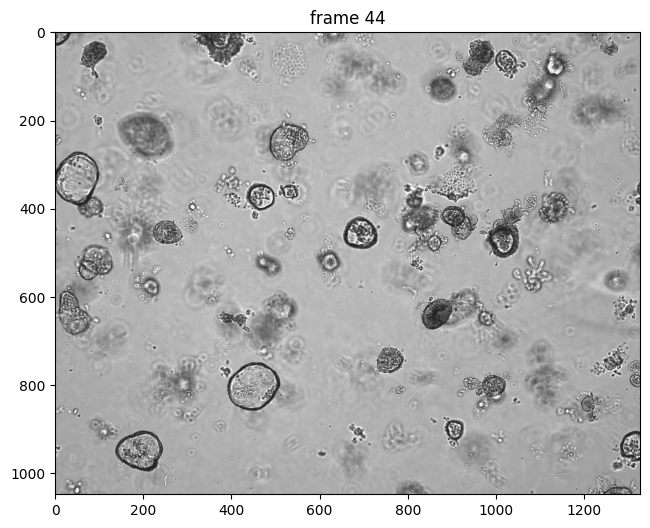

In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/usr/Cell_analysis_DeepLearning/sam2/notebooks/videos/cells/hEnteroid"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 44
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [7]:
import torch
torch.cuda.empty_cache()

inference_state = predictor.init_state(
    video_path=video_dir, 
    offload_video_to_cpu=True  # Offload video to CPU
)


frame loading (JPEG): 100%|██████████| 629/629 [00:15<00:00, 40.98it/s]


#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [8]:
# inference_state = predictor.init_state(video_path=video_dir)

Note that in addition to clicks or boxes, SAM 2 also supports directly using a **mask prompt** as input via the `add_new_mask` method in the `SAM2VideoPredictor` class. This can be helpful in e.g. semi-supervised VOS evaluations (see [tools/vos_inference.py](https://github.com/facebookresearch/sam2/blob/main/tools/vos_inference.py) for an example).

### Segment multiple objects simultaneously

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

In [9]:
predictor.reset_state(inference_state)

#### Step 1: Add two objects on a frame

SAM 2 can also segment and track two or more objects at the same time. One way, of course, is to do them one by one. However, it would be more efficient to batch them together (e.g. so that we can share the image features between objects to reduce computation costs).

This time, let's focus on object parts and segment **the shirts of both childen** in this video. Here we add prompts for these two objects and assign each of them a unique object id.

In [10]:
prompts = {}  # hold all the clicks we add for visualization

Add the first object (the left child's shirt) with a **positive click** at (x, y) = (200, 300) on frame 0.

We assign it to object id `2` (it can be arbitrary integers, and only needs to be unique for each object to track), which is passed to the `add_new_points_or_box` API to distinguish the object we are clicking upon.

/home/praks/Cell_analysis_DeepLearning/sam2/sam2/sam2_video_predictor.py:786: UserWarning: /home/praks/Cell_analysis_DeepLearning/sam2/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


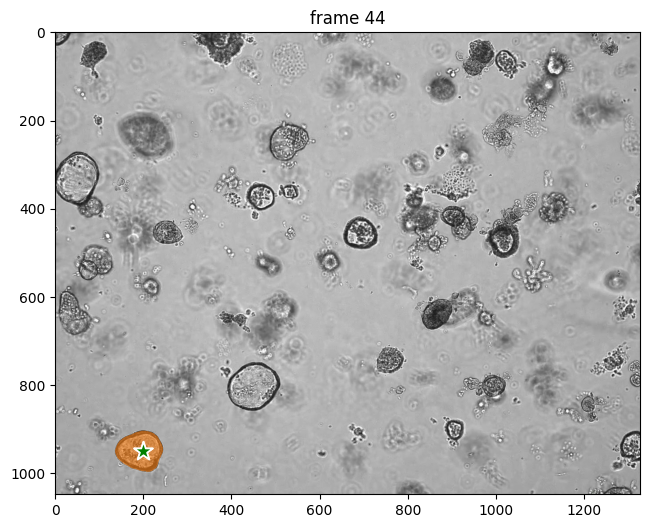

In [11]:
ann_frame_idx = 44  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (200, 300) to get started on the first object
points = np.array([[200, 950]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

Hmm, this time we just want to select the child's shirt, but the model predicts the mask for the entire child. Let's refine the prediction with a **negative click** at (x, y) = (275, 175).

In [12]:
# # add the first object
# ann_frame_idx = 0  # the frame index we interact with
# ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# # Let's add a 2nd negative click at (x, y) = (275, 175) to refine the first object
# # sending all clicks (and their labels) to `add_new_points_or_box`
# points = np.array([[600, 200], [610, 210]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([1, 0], np.int32)
# prompts[ann_obj_id] = points, labels
# _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )

# # show the results on the current (interacted) frame
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
# show_points(points, labels, plt.gca())
# for i, out_obj_id in enumerate(out_obj_ids):
#     show_points(*prompts[out_obj_id], plt.gca())
#     show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

After the 2nd negative click, now we get the left child's shirt as our first object.

Let's move on to the second object (the right child's shirt) with a positive click at (x, y) = (400, 150) on frame 0. Here we assign object id `3` to this second object (it can be arbitrary integers, and only needs to be unique for each object to track).

Note: when there are multiple objects, the `add_new_points_or_box` API will return a list of masks for each object.

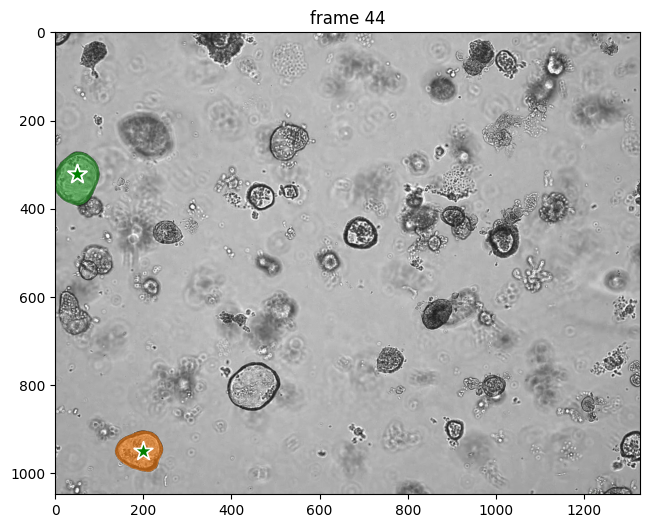

In [13]:
ann_frame_idx = 44  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[50, 320]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

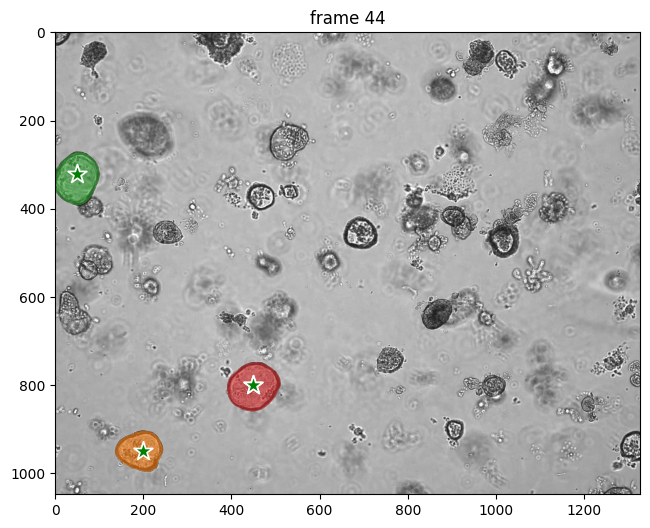

In [14]:
ann_frame_idx = 44  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[450, 800]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [ ]:
# TODO: ONCE I CLICK, directly give me the coordinates, 

#### Step 2: Propagate the prompts to get masklets across the video

Now, we propagate the prompts for both objects to get their masklets throughout the video.

Note: when there are multiple objects, the `propagate_in_video` API will return a list of masks for each object.

propagate in video: 100%|██████████| 585/585 [03:13<00:00,  3.02it/s]


KeyError: 0

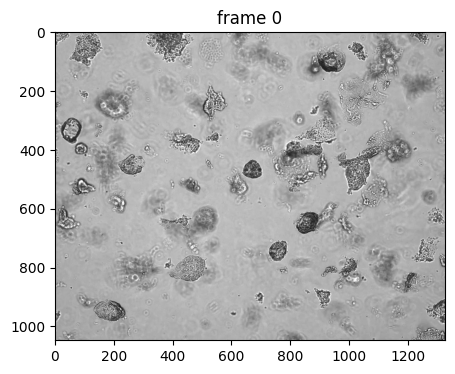

In [ ]:
# run propagation throughout the video and collect the results in a dict

video_segments = {}  # video_segments contains the per-frame segmentation results

for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    
    video_segments[out_frame_idx] = { out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, out_obj_id in enumerate(out_obj_ids)
    }

        

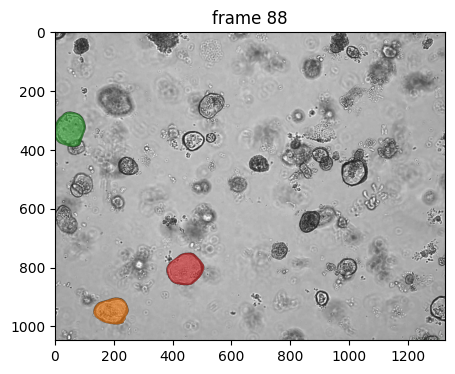

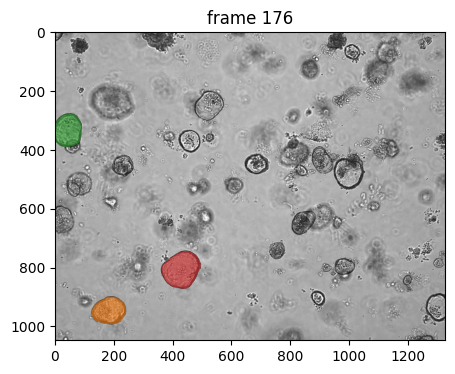

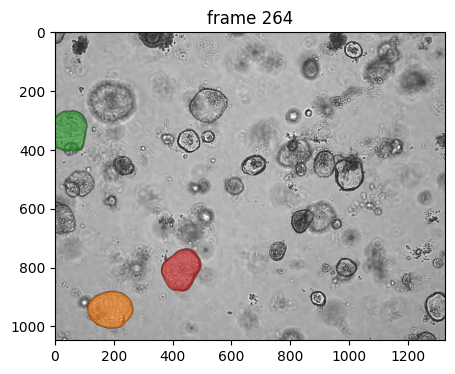

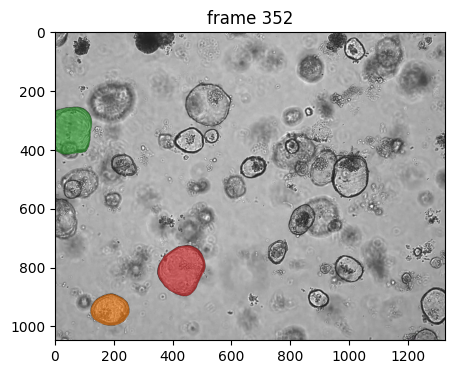

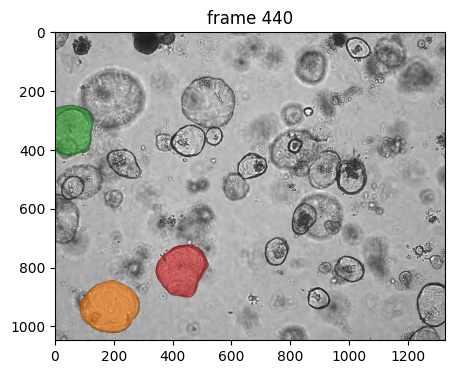

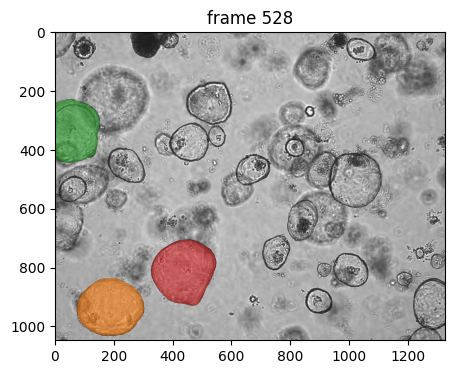

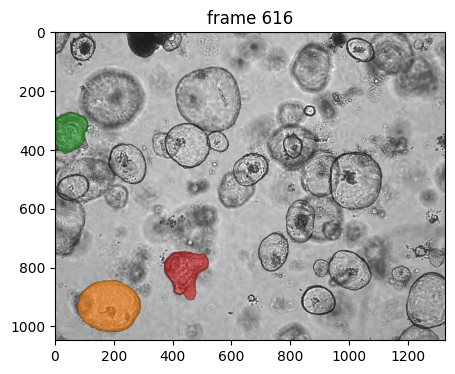

In [21]:
vis_frame_stride = 88
plt.close("all")

# Only consider frames that were propagated and match the stride
valid_frame_indices = sorted(video_segments.keys())
visible_indices = [idx for idx in valid_frame_indices if idx % vis_frame_stride == 0]

for out_frame_idx in visible_indices:
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))

    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)



In [ ]:
# for frame_idx in sorted(video_segments.keys()):
#     print(f"\nFrame {frame_idx}:")
#     for obj_id, mask in video_segments[frame_idx].items():
#         print(f"  Object ID {obj_id}: shape={mask.shape}, dtype={mask.dtype}, unique values={np.unique(mask)}")


###### check if

# Frame 44:
#   Object ID 1: shape=(1, 1048, 1328), dtype=bool, unique values=[False  True]
#   Object ID 2: shape=(1, 1048, 1328), dtype=bool, unique values=[False  True]
#   Object ID 3: shape=(1, 1048, 1328), dtype=bool, unique values=[False  True]

# Frame 45:
#   Object ID 1: shape=(1, 1048, 1328), dtype=bool, unique values=[False  True]
#   Object ID 2: shape=(1, 1048, 1328), dtype=bool, unique values=[False  True]
#   Object ID 3: shape=(1, 1048, 1328), dtype=bool, unique values=[False  True]




In [ ]:
# this gives combined binary masks ---------- only for visulisation 


#  import os
# from PIL import Image
# import numpy as np

# # Selected object IDs
# target_object_ids = [1, 2, 3]

# # Output directory
# output_dir = "combined_binary_masks"
# os.makedirs(output_dir, exist_ok=True)

# for frame_idx, obj_masks in video_segments.items():
#     # Initialize empty (black) mask
#     _, H, W = next(iter(obj_masks.values())).shape
#     combined_mask = np.zeros((H, W), dtype=np.uint8)

#     for obj_id in target_object_ids:
#         if obj_id in obj_masks:
#             mask = obj_masks[obj_id].squeeze()  # shape: (H, W)
#             combined_mask = np.logical_or(combined_mask, mask)

#     # Convert to uint8 and scale for image format
#     combined_mask = (combined_mask.astype(np.uint8)) * 255  # white (255) = mask

#     # Save as grayscale image
#     img = Image.fromarray(combined_mask, mode="L")
#     img.save(os.path.join(output_dir, f"frame_{frame_idx:04d}.png"))


In [22]:
import os
from PIL import Image
import numpy as np

# Selected object IDs (cells)
target_object_ids = [1, 2, 3]

# Base output directory
base_output_dir = "per_object_binary_masks"

# Create a separate subdirectory for each object ID
for obj_id in target_object_ids:
    os.makedirs(os.path.join(base_output_dir, f"object_{obj_id}"), exist_ok=True)

# Loop through each frame and save masks per object
for frame_idx, obj_masks in video_segments.items():
    for obj_id in target_object_ids:
        if obj_id in obj_masks:
            # Remove singleton dimension: shape (1, H, W) → (H, W)
            mask = obj_masks[obj_id].squeeze()
            binary_mask = (mask.astype(np.uint8)) * 255  # white = mask

            # Save image
            img = Image.fromarray(binary_mask, mode="L")
            output_path = os.path.join(base_output_dir, f"object_{obj_id}", f"frame_{frame_idx:04d}.png")
            img.save(output_path)


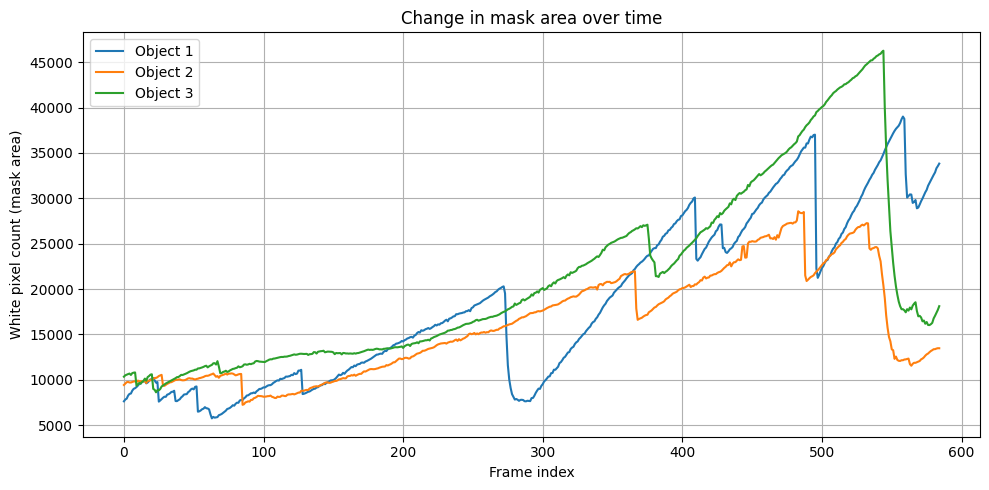

In [23]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Object IDs
target_object_ids = [1, 2, 3]

# Base path where folders are stored
base_output_dir = "per_object_binary_masks"

# Dictionary to hold pixel counts over time
pixel_counts = {obj_id: [] for obj_id in target_object_ids}

# Collect white pixel counts for each object
for obj_id in target_object_ids:
    obj_dir = os.path.join(base_output_dir, f"object_{obj_id}")
    frame_files = sorted(os.listdir(obj_dir))

    for fname in frame_files:
        mask = Image.open(os.path.join(obj_dir, fname)).convert("L")
        mask_np = np.array(mask)
        white_pixels = np.sum(mask_np == 255)
        pixel_counts[obj_id].append(white_pixels)

# Plotting
plt.figure(figsize=(10, 5))
for obj_id in target_object_ids:
    plt.plot(pixel_counts[obj_id], label=f"Object {obj_id}")

plt.xlabel("Frame index")
plt.ylabel("White pixel count (mask area)")
plt.title("Change in mask area over time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


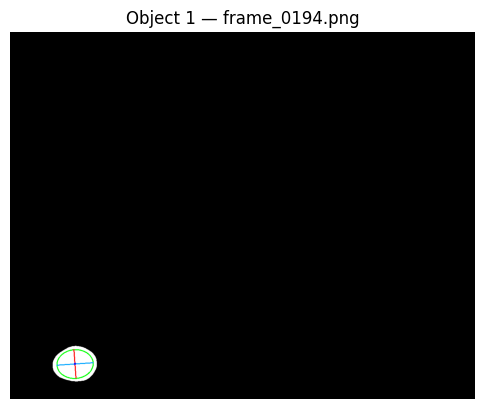

In [152]:
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import os

# Pick a random object ID and a random frame from its folder
obj_id = 1  # or 1, 2, 3
obj_dir = os.path.join("per_object_binary_masks", f"object_{obj_id}")
frame_files = sorted(os.listdir(obj_dir))
frame_file = random.choice(frame_files)

# Load binary mask
mask = Image.open(os.path.join(obj_dir, frame_file)).convert("L")
mask_np = np.array(mask)
coords = np.column_stack(np.where(mask_np == 255))  # (y, x)

# Convert to (x, y) float32 for OpenCV
coords_xy = coords[:, [1, 0]].astype(np.float32)

if len(coords_xy) >= 5:
    ellipse = cv2.fitEllipse(coords_xy)
    (cx, cy), (major_len, minor_len), angle_deg = ellipse

    # Convert angle to radians
    angle_rad = np.deg2rad(angle_deg)

    # Major axis vector
    dx_major = (major_len / 2) * np.cos(angle_rad)
    dy_major = (major_len / 2) * np.sin(angle_rad)

    # Minor axis vector (perpendicular to major)
    dx_minor = (minor_len / 2) * np.cos(angle_rad + np.pi/2)
    dy_minor = (minor_len / 2) * np.sin(angle_rad + np.pi/2)

    # Endpoints for major and minor axes
    pt_major_1 = (int(cx - dx_major), int(cy - dy_major))
    pt_major_2 = (int(cx + dx_major), int(cy + dy_major))

    pt_minor_1 = (int(cx - dx_minor), int(cy - dy_minor))
    pt_minor_2 = (int(cx + dx_minor), int(cy + dy_minor))

    # Convert grayscale to BGR for visualization
    output_img = cv2.cvtColor(mask_np, cv2.COLOR_GRAY2BGR)

    # Draw ellipse
    cv2.ellipse(output_img, ellipse, (0, 255, 0), 2)  # green

    # Draw major axis (blue)
    cv2.line(output_img, pt_major_1, pt_major_2, (255, 0, 0), 2)

    # Draw minor axis (orange)
    cv2.line(output_img, pt_minor_1, pt_minor_2, (0, 165, 255), 2)

    # Draw center (red dot)
    cv2.circle(output_img, (int(cx), int(cy)), 3, (0, 0, 255), -1)

    # Show result
    plt.figure(figsize=(6, 6))
    plt.title(f"Object {obj_id} — {frame_file}")
    plt.imshow(output_img)
    plt.axis("off")
    plt.show()
else:
    print("Not enough points to fit ellipse.")


In [64]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Object IDs
target_object_ids = [1, 2, 3]
base_output_dir = "per_object_binary_masks"

# Store axis lengths over frames
axes_lengths = {obj_id: {"major": [], "minor": []} for obj_id in target_object_ids}

for obj_id in target_object_ids:
    obj_dir = os.path.join(base_output_dir, f"object_{obj_id}")
    frame_files = sorted(os.listdir(obj_dir))

    for fname in frame_files:
        mask = Image.open(os.path.join(obj_dir, fname)).convert("L")
        mask_np = np.array(mask)
        coords = np.column_stack(np.where(mask_np == 255))  # (y, x)

        if len(coords) >= 5:
            # Swap to (x, y) format for OpenCV
            coords_xy = coords[:, [1, 0]].astype(np.float32)
            ellipse = cv2.fitEllipse(coords_xy)
            (center_x, center_y), (major, minor), angle = ellipse
            axes_lengths[obj_id]["major"].append(max(major, minor))  # Ensure major ≥ minor
            axes_lengths[obj_id]["minor"].append(min(major, minor))
        else:
            # Not enough points for ellipse fitting — append NaN
            axes_lengths[obj_id]["major"].append(np.nan)
            axes_lengths[obj_id]["minor"].append(np.nan)


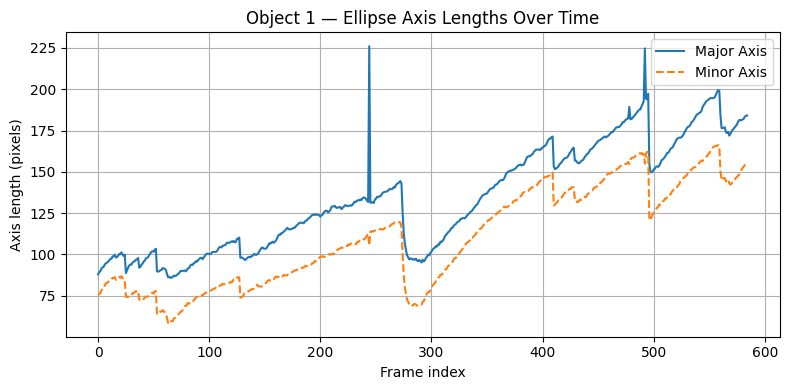

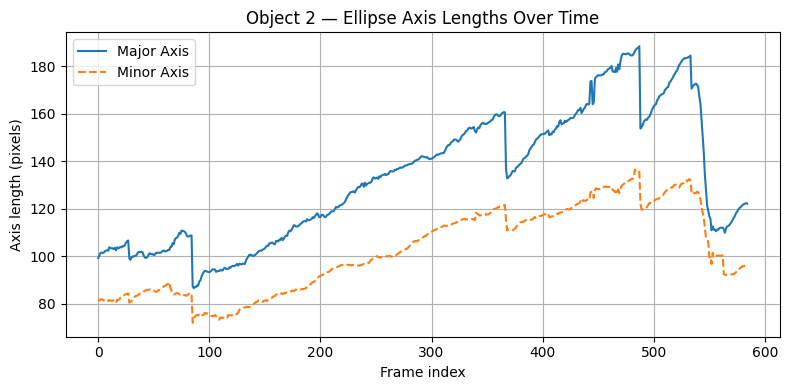

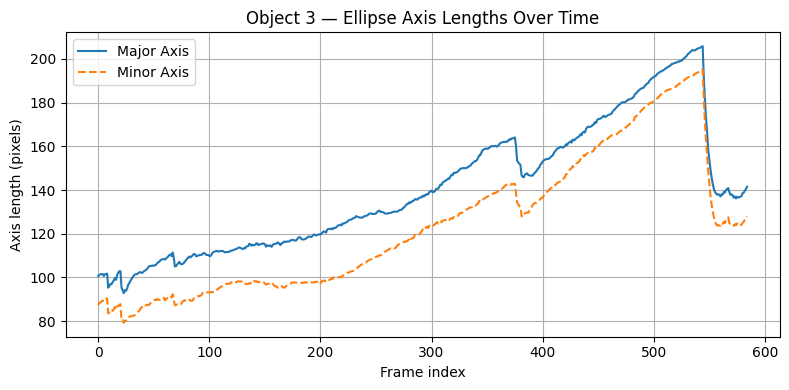

In [ ]:
import matplotlib.pyplot as plt

# Create separate plots for each object
for obj_id in target_object_ids:
    plt.figure(figsize=(8, 4))
    plt.plot(axes_lengths[obj_id]["major"], label="Major Axis", linestyle='-')
    plt.plot(axes_lengths[obj_id]["minor"], label="Minor Axis", linestyle='--')
    plt.xlabel("Frame index")
    plt.ylabel("Axis length (pixels)")
    plt.title(f"Object {obj_id} — Ellipse Axis Lengths Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ## TODO: take average and display all three together

    #### Average interval between two contractions - if the profile decreases by some threshold, then its a contraction


In [ ]:
### TODO: converting from pixels to microns 

# Check the microscope's documentation or the camera's specifications for the pixel size in microns per pixel


# Divide the field of view (in microns) by the number of 
# pixels in the corresponding direction (e.g., field of view width / image width in pixels)

# If the pixel size is unknown, you can use a micrometer graticule (a calibration tool with known distances) 
# to measure a known distance in pixels and determine the pixel size


##############################################
# Multiply: Once you have the pixel size, multiply the measured distance in pixels by the pixel size to get the corresponding distance in microns. 
# Example: If a line in your image is 2000 pixels long and the pixel size is 0.1 μm/pixel, then the length is 2000 * 0.1 = 200 μm



########### 0.5 pixels/micron 
# we can use or divide the same conversion factor by three in the next video. 


In [2]:
45000 * 0.5


22500.0